In [1]:
%%time
import pandas as pd
import os
import boto3
import re
import sagemaker
import numpy as np
import json

## local
cred=json.load(open('../../.awscred','r'))
botoSession = boto3.Session(aws_access_key_id=cred['aws_access_key'],
                      aws_secret_access_key=cred['aws_secret_access_key'],
                      region_name='us-east-1')
s3_client = botoSession.client("s3")
sagemakerSession=sagemaker.Session(boto_session=botoSession)
# ### Below returns user but we need role , using role arn from IAM

# # # # sagemaker.get_execution_role(sagemaker_session=sagemakerSession)
region = botoSession.region_name
role='arn:aws:iam::032934527328:role/service-role/AmazonSageMaker-ExecutionRole-20201011T181292'
# # sagemaker managed notebook
# role = sagemaker.get_execution_role()
# region = boto3.Session().region_name
# s3_client = boto3.client("s3")

data_bucket = "abhijit-s3-bucket-name"
output_prefix='output'

CPU times: user 632 ms, sys: 133 ms, total: 765 ms
Wall time: 470 ms


In [5]:
s3_client.list_buckets()

{'ResponseMetadata': {'RequestId': '5JQ2BXQ3ETD4MYMR',
  'HostId': 'eCIfWC5lIkg3rf2/RuHA73S7vgNmra1qjnNTsBFtciuk8ZGZO6eaXVtHeeQK+7ETW0Fs9wgcX5s=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'eCIfWC5lIkg3rf2/RuHA73S7vgNmra1qjnNTsBFtciuk8ZGZO6eaXVtHeeQK+7ETW0Fs9wgcX5s=',
   'x-amz-request-id': '5JQ2BXQ3ETD4MYMR',
   'date': 'Sun, 11 Sep 2022 12:46:43 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'abhijit-s3-bucket-name',
   'CreationDate': datetime.datetime(2020, 10, 11, 22, 28, 32, tzinfo=tzutc())},
  {'Name': 'aws-cloudtrail-logs-032934527328-a57c6005',
   'CreationDate': datetime.datetime(2022, 8, 28, 14, 45, 53, tzinfo=tzutc())},
  {'Name': 'elasticbeanstalk-us-east-1-032934527328',
   'CreationDate': datetime.datetime(2018, 11, 20, 6, 9, 23, tzinfo=tzutc())},
  {'Name': 'isolationforest',
   'CreationDate': datetime.datetime(2022, 8, 15, 1, 25, 22, tzinfo=tzutc())},


In [21]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
df=load_iris()
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.5)
train=np.concatenate((y_train.reshape(-1,1),X_train),axis=1)
test=np.concatenate((y_test.reshape(-1,1),X_test),axis=1)

In [22]:
def upload_train_data_s3(localname,data,output_bucket, output_key):
    np.savetxt(localname,data,delimiter=',')
    s3_client.upload_file(localname,output_bucket, output_key+'/'+localname)
    
upload_train_data_s3('train.csv',train,data_bucket,'train')
upload_train_data_s3('test.csv',test,data_bucket,'test')

In [2]:
xgbcontainer=sagemaker.image_uris.get_training_image_uri(region,'xgboost',framework_version='latest')
xgbcontainer

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

In [4]:
%%time
from time import gmtime, strftime

job_name = f"xgboost-iris-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print("Training job", job_name)

# Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = {
    "AlgorithmSpecification": {"TrainingImage": xgbcontainer, "TrainingInputMode": "File"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": f"s3://{data_bucket}/output/single-xgboost"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m5.large", "VolumeSizeInGB": 5},
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth": "5",
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "objective": "multi:softmax",
        "num_round": "5",
        "verbosity": "2",
        "num_class": "3",

    },
    "StoppingCondition": {"MaxWaitTimeInSeconds":600,
                          "MaxRuntimeInSeconds": 600},
    "EnableManagedSpotTraining": True,
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"s3://{data_bucket}/train",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None",
        }
    ],
}

# sagemaker notebook
# client = boto3.client("sagemaker", region_name=region)
#local
client = botoSession.client("sagemaker", region_name=region)
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(10)
    status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
    print(status)

Training job xgboost-iris-2022-09-11-12-49-37
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
CPU times: user 890 ms, sys: 88.8 ms, total: 979 ms
Wall time: 3min 45s


In [6]:
job_name="xgboost-iris-2022-08-29-02-46-38"
client = boto3.client("sagemaker", region_name=region)

In [9]:
%%time
import boto3
from time import gmtime, strftime

model_name = f"{job_name}-model"
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {"Image": xgbcontainer, "ModelDataUrl": model_data}

create_model_response = client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

# print(create_model_response["ModelArn"])

xgboost-iris-2022-08-29-02-46-38-model
s3://abhijit-s3-bucket-name/output/single-xgboost/xgboost-iris-2022-08-29-02-46-38/output/model.tar.gz
CPU times: user 15.9 ms, sys: 4.57 ms, total: 20.5 ms
Wall time: 492 ms


In [10]:
from time import gmtime, strftime

endpoint_config_name = f"XGBoost-Iris-EndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print(f"Endpoint Config Arn: {create_endpoint_config_response['EndpointConfigArn']}")

XGBoost-Iris-EndpointConfig-2022-08-29-19-14-47
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:032934527328:endpoint-config/xgboost-iris-endpointconfig-2022-08-29-19-14-47


In [11]:
%%time
import time

endpoint_name = f'XGBoost-Iris-Endpoint-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
while status == "Creating":
    print(f"Status: {status}")
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]

print(f"Arn: {resp['EndpointArn']}")
print(f"Status: {status}")

XGBoost-Iris-Endpoint-2022-08-29-19-16-49
arn:aws:sagemaker:us-east-1:032934527328:endpoint/xgboost-iris-endpoint-2022-08-29-19-16-49
Status: Creating
Status: Creating
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:032934527328:endpoint/xgboost-iris-endpoint-2022-08-29-19-16-49
Status: InService
CPU times: user 52 ms, sys: 12.9 ms, total: 64.9 ms
Wall time: 3min


In [16]:
runtime_client = boto3.client("runtime.sagemaker", region_name=region)

In [25]:
with open('X_test.csv', "r") as f:
    payload = f.readline().rstrip()

In [26]:
payload

'6.700000000000000178e+00,3.100000000000000089e+00,4.400000000000000355e+00,1.399999999999999911e+00'

In [23]:
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="text/csv", Body=payload
)

In [24]:
response['Body'].read()

b'1.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,2.0'

# POSTMAN

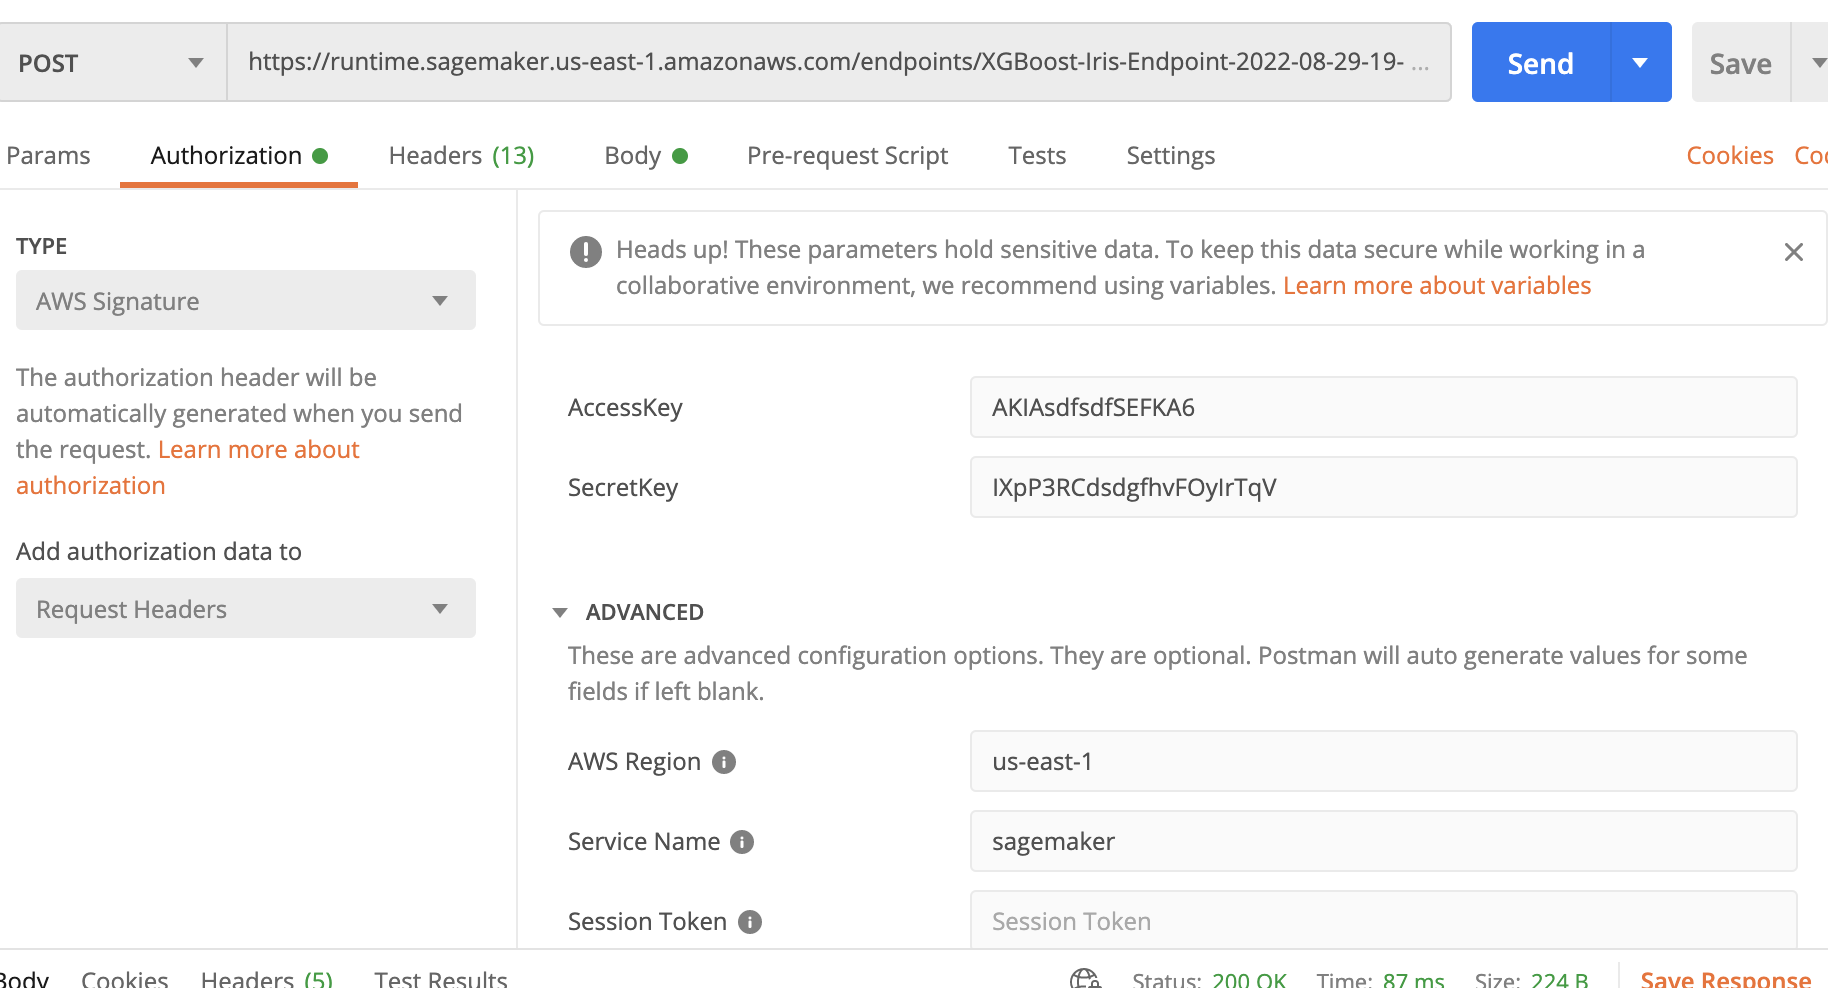

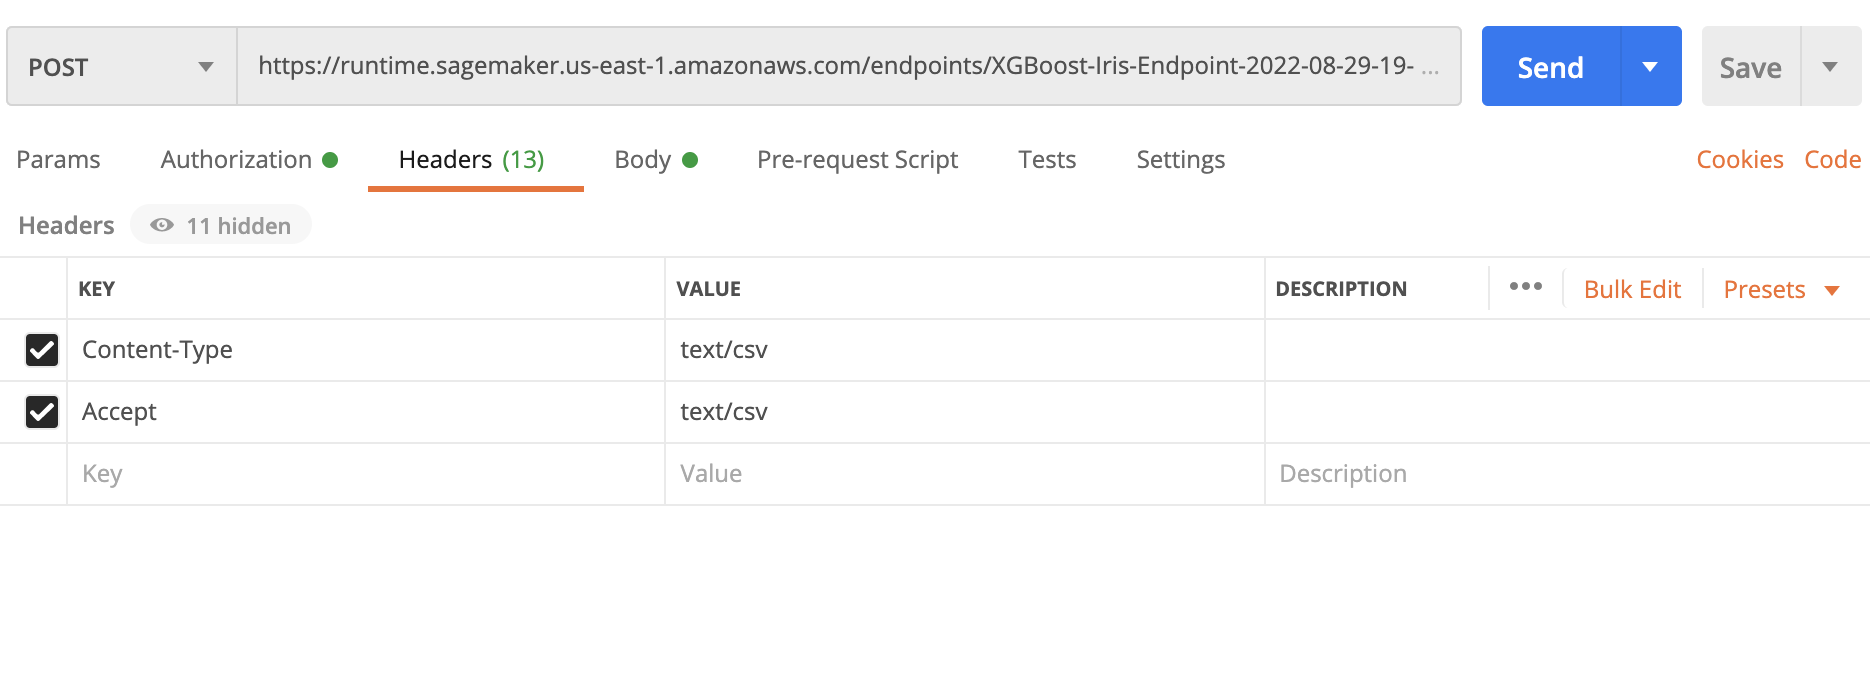

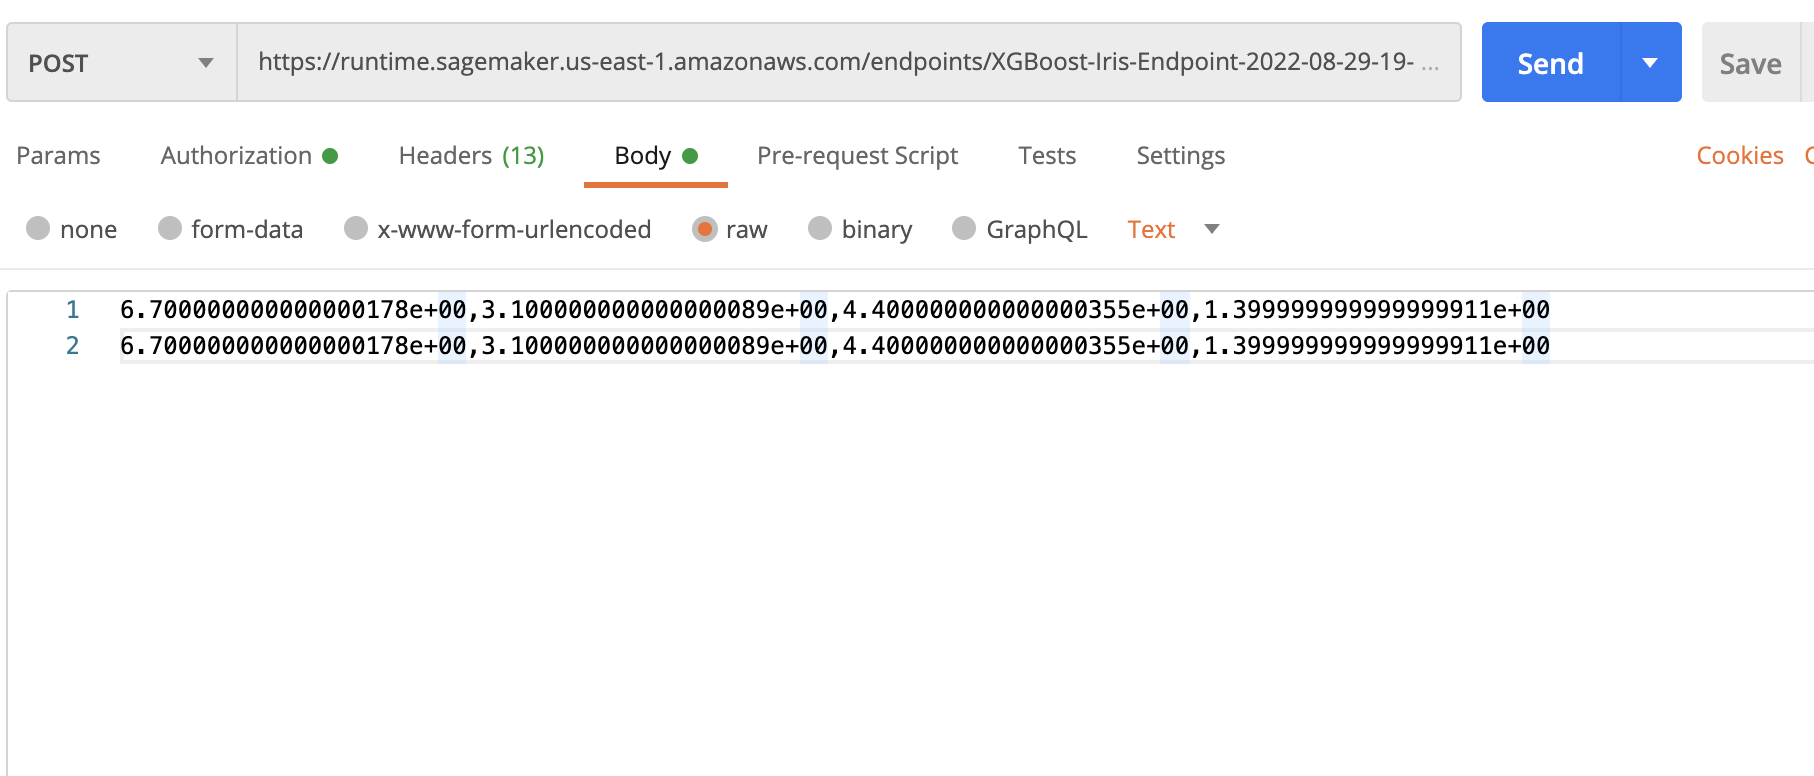